Notebook to produce data regarding 2023 Holiday Service:
https://caltrans.sharepoint.com/:w:/s/DOTPMPHQ-DataandDigitalServices/EVEcAgAwsK1AhL7pQDa22TcBlLF5ZLF-SYOGORhrQrIOCA?e=BX6lkA

There are a significant number of duplicate gtfs files for agencies and it is hard to parse through which is relevant for this research.

Steps:
- Pulls holiday website research data from Services Airtable
- Pulls appropriate agency names from intermediate mart table int_gtfs_quality__daily_assessment_candidate_entities
- Uses these names to query fct_scheduled_trips on holiday and reference dates
- Divide holiday service levels by reference service levels, appropriate by whether the holiday is a weekday or Saturday or Sunday
- Prescribe a gtfs service level by fraction
- Create confusion matrices
- Make another plot



TODOs:
- Instead of query by name, make a join between int_gtfs_quality__daily_assessment_candidate_entities and fct_scheduled_trips by the appropriate method.  This will prevent issues where the gtfs schedule name changes will affect the joins.  This should help ensure the analysis is perfectly replicable in the future.
- Refactor so there aren't multiple lists of text columns
- Method-chain the transformations

In [1]:
from dotenv import load_dotenv
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyairtable import Api
import seaborn as sns  # For visualization (optional)
from sklearn.metrics import confusion_matrix

load_dotenv()
api = Api(os.getenv('AIRTABLE_TOKEN'))

os.environ["CALITP_BQ_MAX_BYTES"] = str(20_000_000_000)
from calitp_data_analysis.sql import query_sql

In [2]:
# Trying to stay consistent with 
# https://github.com/cal-itp/data-infra/blob/main/airflow/plugins/operators/airtable_to_gcs.py
def all_rows_as_df(base_id, table_name):
    all_rows = api.table(base_id=base_id, table_name=table_name).all()

    df = pd.DataFrame(
        [
            {"id":row["id"], **row["fields"]}
            for row in all_rows
        ]
    )
    return df

def takeout_list(x):
    if x is not np.nan:
        return x[0]

CALIFORNIA_TRANSIT_ID = "appPnJWrQ7ui4UmIl"
SERVICES_ID = 'tbl9YmMrJ14D5oPSV'
GTFS_SERVICES = 'tblnVt5FZ2FZmDjDx'
services_df = all_rows_as_df(CALIFORNIA_TRANSIT_ID, SERVICES_ID)
services_df['Total VOMS (NTD) (from Provider)'] = services_df['Total VOMS (NTD) (from Provider)'].apply(takeout_list)
gtfs_services = all_rows_as_df(CALIFORNIA_TRANSIT_ID, GTFS_SERVICES)

In [3]:
#This was the best I could come up with to cover everything that service was calculated for.
services_df = services_df.loc[~services_df['Holiday Schedule – Veterans Day'].isnull(),]
services_df = services_df.loc[services_df['Public Currently Operating Fixed Route'] == 'Yes',]

#loses bear transit
#Multiple transit agencies with no GTFS
#Worried about Samtrans, and VTA, and whichever use Bay Area Regional Transit since they have 511 duplicates

In [4]:
services_df.head()

,id,Name,Notes,Provider,website,Service Type,Mode,Rider Requirements,Currently Operating,Funding Sources,...,Product: Payments,Deprecated Date,Next Steps,New Contact Info (from USDOT),Context from Juliet,Season Start,Season End,eligibility programs,Start Date,organizations 2
4,rec0NVDERfqlUEB3t,Unitrans,Unitrans provides public transportation servic...,[recS1JKEz73Hev8pJ],https://unitrans.ucdavis.edu/,[fixed-route],[bus],[rec9S3diP9OKrofzL],True,"[recZryp2SxNi6PPCE, recnSZgsw8HT1zV4a, recZMEr...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,rec0es9vxcDpyvJJA,Simi Valley Transit,NaN,[rec1ErIn9gG1Isk5W],https://www.simivalley.org/departments/public-...,[fixed-route],[bus],[rec9S3diP9OKrofzL],True,"[recZryp2SxNi6PPCE, recnSZgsw8HT1zV4a]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,rec0xnHrKjJMoUUq0,Altamont Corridor Express,ACE offers four weekday roundtrips with 10 sto...,[recpgYVeU3VePMeWx],https://acerail.com/,[fixed-route],[commuter rail],[rec9S3diP9OKrofzL],True,"[recZryp2SxNi6PPCE, recnSZgsw8HT1zV4a, recArkR...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,rec1ytJS0RhP0SVfr,Arvin Transit,City of Arvin Transportation Department is kno...,[recU2uRqDJL4SdI4E],https://www.arvin.org/202/Routes-Schedules-Fares,[fixed-route],[bus],[rec9S3diP9OKrofzL],True,[recLdRD2ijGYB2Xwm],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,rec1zNYEtqhtUpvXY,Placer County Transit,Placer County Transit (PCT) provides transport...,[recDD2rnkl2m7IV8u],https://placercountytransit.com/,[fixed-route],[bus],[rec9S3diP9OKrofzL],True,"[recZryp2SxNi6PPCE, recLdRD2ijGYB2Xwm, recnSZg...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
int_entities = query_sql("""
SELECT 
gtfs_dataset_name,
service_source_record_id,
gtfs_service_data_source_record_id,
use_subfeed_for_reports,
regional_feed_type
FROM `cal-itp-data-infra.staging.int_gtfs_quality__daily_assessment_candidate_entities` 
WHERE gtfs_dataset_type = 'schedule'
AND
date = '2024-01-29'
AND
gtfs_dataset_name != "Bay Area 511 Regional Schedule"
order by organization_name, gtfs_dataset_name ASC
""", as_df=True)
# int_entities

In [6]:
int_entities = pd.merge(int_entities,gtfs_services[['id','Customer Facing']], how='left', left_on='gtfs_service_data_source_record_id',right_on='id').drop(labels=['id'],axis=1)

In [7]:
int_entities = int_entities.query("use_subfeed_for_reports==False | regional_feed_type=='Regional Subfeed'")

In [8]:
#Missing gtfs ones
services_df.loc[services_df['id'].isin(set(services_df['id'].values).difference(set(int_entities['service_source_record_id'].values))),]

,id,Name,Notes,Provider,website,Service Type,Mode,Rider Requirements,Currently Operating,Funding Sources,...,Product: Payments,Deprecated Date,Next Steps,New Contact Info (from USDOT),Context from Juliet,Season Start,Season End,eligibility programs,Start Date,organizations 2
54,rec4xLfuGtCQ5kwrI,AquaLink,AquaBus is not in service until further notice...,[rec00qSzZL8KqiXAo],https://ridelbt.com/aqualink/,[fixed-route],[ferry],[rec9S3diP9OKrofzL],NaN,"[recQWMAX0lIUz2Q7h, recnSZgsw8HT1zV4a, recZMEr...",...,NaN,NaN,NaN,"Gaby Marquez, GIS/ITS Analyst, gmarquez@lbtran...",NaN,NaN,NaN,NaN,NaN,NaN
99,rec9GidVJcFDm23qx,Yosemite Valley Shuttles,The free Yosemite Valley shuttle system provid...,[recg58MziBRsVfavn],http://home.nps.gov/yose/planyourvisit/publict...,NaN,[bus],[rec9S3diP9OKrofzL],True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,rec9thmtC83JK3wLV,Tuolumne County Transit,Tuolumne County Transit has operates routes wi...,[reclbzT9trIiGwjBB],https://www.tuolumnecountytransit.com/,"[deviated fixed-route, reservations]",[bus],[rec9S3diP9OKrofzL],True,"[recZryp2SxNi6PPCE, recLdRD2ijGYB2Xwm, reccFBO...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,recC0m5jRWg4AY3t1,Balboa Peninsula Trolley,The Balboa Peninsula Trolley is a free service...,[rectXzoXm6gBuNBHK],https://www.visitnewportbeach.com/balboa-penin...,NaN,NaN,[rec9S3diP9OKrofzL],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,May,Labor Day,NaN,NaN,NaN
368,recXhJlHUJHTM5HPu,Ohana Dana Point Trolley,NaN,[receSouvQI31vHz4D],https://danapointchamber.com/dana-point-trolley/,[fixed-route],NaN,[rec9S3diP9OKrofzL],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,May,Labor Day,NaN,NaN,NaN
443,recg0Sy5cqunBqWdh,San Clemente Trolley,Seasonal free summer trolley.\n\n2023 Trolley ...,[recwtQ7m3C59jbnrc],https://www.san-clemente.org/about-us/city-new...,"[fixed-route, seasonal]",[trolley/streetcar],[rec9S3diP9OKrofzL],True,[recQWMAX0lIUz2Q7h],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468,reciRN9UfU7aPHkAO,Mountain View Community Shuttle,The Mountain View Community Shuttle is provide...,[rec4pDiUorjWbUfvU],https://mvcommunityshuttle.com/,NaN,NaN,[rec9S3diP9OKrofzL],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
495,reckS7ev5tYaabUlN,Santa Cruz Harbor Water Taxi,Taxi operates on summer weekends and holidays ...,[recNSGNAyM91vsTU7],https://www.santacruzharbor.org/harbor-water-t...,[deviated fixed-route],[ferry],[rec9S3diP9OKrofzL],True,[recpPjUOODbqUQ8Kn],...,NaN,NaN,NaN,NaN,NaN,Memorial Day,Labor Day,NaN,NaN,NaN
498,reckhgOj3efNz3vi1,Beverly Hills Trolley,Free Trolley.\nResumed service.,[rec6suFcJnXKb8ARd],http://www.beverlyhills.org/departments/public...,[fixed-route],[trolley/streetcar],[rec9S3diP9OKrofzL],True,[recZryp2SxNi6PPCE],...,NaN,NaN,"Sent follow-up email on 5/31, no response yet","Aaron Kunz, Deputy Directory of Transportation...",Either couldn't find contact info in the first...,NaN,NaN,NaN,NaN,NaN


In [9]:
services_plus_service_names = pd.merge(services_df,int_entities[['service_source_record_id','gtfs_dataset_name','Customer Facing']]
                                       ,left_on='id',right_on='service_source_record_id',how='left',indicator=True)

In [10]:
services_plus_service_names[['Name','Notes']].loc[services_plus_service_names['gtfs_dataset_name'].isnull(),]

,Name,Notes
17,AquaLink,AquaBus is not in service until further notice...
27,Yosemite Valley Shuttles,The free Yosemite Valley shuttle system provid...
28,Tuolumne County Transit,Tuolumne County Transit has operates routes wi...
34,Balboa Peninsula Trolley,The Balboa Peninsula Trolley is a free service...
113,Ohana Dana Point Trolley,NaN
139,San Clemente Trolley,Seasonal free summer trolley.\n\n2023 Trolley ...
144,Mountain View Community Shuttle,The Mountain View Community Shuttle is provide...
152,Santa Cruz Harbor Water Taxi,Taxi operates on summer weekends and holidays ...
155,Beverly Hills Trolley,Free Trolley.\nResumed service.


In [11]:
#Remove above entries that have no gtfs_dataset_name
services_plus_service_names = services_plus_service_names.loc[~services_plus_service_names['gtfs_dataset_name'].isnull(),]
len(set(services_plus_service_names['service_source_record_id'].values))

191

In [12]:
holiday_columns= ["Holiday Schedule – Thanksgiving Day",
"Holiday Schedule – Christmas Day",
"Holiday Schedule – New Year's Day",
"Holiday Schedule – MLK Day",
"Holiday Schedule – Veterans Day (Observed)",
"Holiday Schedule – Veterans Day",
"Holiday Schedule – Day after Thanksgiving Day",
"Holiday Schedule – Christmas Eve",
"Holiday Schedule – New Year’s Eve",
"Holiday Schedule Notes"]

In [13]:
# Define holidays
holidays_plus_ref = [
    {
        'name': "Veterans Day (Observed)",
        'website_name': "Holiday Schedule – Veterans Day (Observed)",
        'date': '2023-11-10',
    }, {
        'name': "Veterans Day",
        'website_name': "Holiday Schedule – Veterans Day",
        'date': '2023-11-11',
    }, {
        'name': "Thanksgiving Day",
        'website_name': "Holiday Schedule – Thanksgiving Day",
        'date': '2023-11-23',
    }, {
        'name': "Day After Thanksgiving",
        'website_name': "Holiday Schedule – Day after Thanksgiving Day",
        'date': '2023-11-24',
    }, {
        'name': "Christmas Eve",
        'website_name': "Holiday Schedule – Christmas Eve",
        'date': '2023-12-24',
    }, {
        'name': "Christmas Day",
        'website_name': "Holiday Schedule – Christmas Day",
        'date': '2023-12-25',
    }, {
        'name': "New Year's Eve",
        'website_name': "Holiday Schedule – New Year’s Eve",
        'date': '2023-12-31',
    }, {
        'name': "New Year's Day",
        'website_name': "Holiday Schedule – New Year's Day",
        'date': '2024-01-01',
    }, {
        'name': "MLK Day",
        'website_name': "Holiday Schedule – MLK Day",
        'date': '2024-01-15',
    }, {
        'name': "Reference Weekday",
        'date': '2023-12-14',
    }, {
        'name': "Reference Saturday",
        'date': '2023-11-25',
    }, {
        'name': "Reference Sunday",
        'date': '2023-12-17',
    },
]

In [14]:
text_data_cols = [
"Holiday Schedule – Thanksgiving Day",
"Holiday Schedule – Christmas Day",
"Holiday Schedule – New Year's Day",
"Holiday Schedule – MLK Day",
"Holiday Schedule – Veterans Day (Observed)",
"Holiday Schedule – Veterans Day",
"Holiday Schedule – Day after Thanksgiving Day",
"Holiday Schedule – Christmas Eve", 
"Holiday Schedule – New Year’s Eve",
"Veterans Day (Observed)",
"Veterans Day", 
"Thanksgiving Day", 
"Day After Thanksgiving",
"Christmas Eve", 
"Christmas Day", 
"New Year's Eve", 
"New Year's Day",
"MLK Day"]

In [15]:
days_to_consider = []
for each in holidays_plus_ref:
    days_to_consider += [each['date']]

dates_for_query = ','.join(map("'{0}'".format, days_to_consider))

#DowneyLINK replaced their GTFS name from DowneyLINK Schedule to DowneyLINK GMV Schedule on Jan 1st, 2024.  
#This will help collect all their data from both 2023 and 2024.
transit_names_for_query = ','.join(map("'{0}'".format, services_plus_service_names['gtfs_dataset_name'].values)) + ", 'DowneyLINK Schedule'"

In [16]:
trips = query_sql(f"""
select name, service_date, count(trip_instance_key) as total_trips
from `cal-itp-data-infra.mart_gtfs.fct_scheduled_trips` 
WHERE
service_date in ({dates_for_query})
AND
name in ({transit_names_for_query})
group by name, service_date 
""", as_df=True)
trips

#This will consolidate DowneyLink data.
trips = trips.replace(to_replace={'DowneyLINK Schedule':'DowneyLINK GMV Schedule'})

date_to_name = {}
for element in holidays_plus_ref:
    date_to_name[element['date']]=element['name']
trips['service_date'] = pd.to_datetime(trips['service_date']).dt.strftime(date_format='%Y-%m-%d')
trips = trips.replace({"service_date":date_to_name})

#https://hackersandslackers.com/reshaping-pandas-dataframes/
trips_pivoted = pd.pivot_table(trips, index='name',columns='service_date',fill_value = 0,values='total_trips')

In [50]:
trips_pivoted['Reference Sunday'].sum()

59938

In [51]:
trips_pivoted

service_date,Christmas Day,Christmas Eve,Day After Thanksgiving,MLK Day,New Year's Day,New Year's Eve,Reference Saturday,Reference Sunday,Reference Weekday,Thanksgiving Day,Veterans Day,Veterans Day (Observed)
name,,,,,,,,,,,,
Alhambra Schedule,0,0,0,0,0,0,34,0,101,0,0,101
Amador Schedule,0,0,0,0,0,0,0,0,29,0,0,0
Amtrak Schedule,603,627,701,698,657,644,609,643,760,612,604,729
Anaheim Resort Schedule,5329,5161,4813,7418,7517,5183,4991,4667,4835,5155,4810,4632
Antelope Valley Transit Authority Schedule,0,238,552,552,0,238,274,238,552,0,274,552
...,...,...,...,...,...,...,...,...,...,...,...,...
YARTS Schedule,0,9,9,9,0,9,9,9,9,0,9,9
Yolobus Schedule,119,119,149,149,0,119,124,119,172,119,124,149
Yuba-Sutter Schedule,0,0,195,0,0,0,145,0,213,225,145,221


In [53]:
df_with_data = pd.merge(services_plus_service_names[['Name','Notes','gtfs_dataset_name','Total VOMS (NTD) (from Provider)', 'Customer Facing']+holiday_columns], trips_pivoted.reset_index(),how='left', left_on='gtfs_dataset_name', right_on='name',indicator=True)
df_with_data

,Name,Notes,gtfs_dataset_name,Total VOMS (NTD) (from Provider),Customer Facing,Holiday Schedule – Thanksgiving Day,Holiday Schedule – Christmas Day,Holiday Schedule – New Year's Day,Holiday Schedule – MLK Day,Holiday Schedule – Veterans Day (Observed),...,MLK Day,New Year's Day,New Year's Eve,Reference Saturday,Reference Sunday,Reference Weekday,Thanksgiving Day,Veterans Day,Veterans Day (Observed),_merge
0,Unitrans,Unitrans provides public transportation servic...,Unitrans Schedule,35.0,True,No service,No service,Reduced service,Reduced service,Reduced service,...,122.0,0.0,0.0,122.0,122.0,911.0,0.0,122.0,122.0,both
1,Simi Valley Transit,NaN,Simi Valley Schedule,17.0,NaN,No service,No service,No service,Regular service,Regular service,...,115.0,115.0,0.0,103.0,0.0,115.0,115.0,103.0,115.0,both
2,Simi Valley Transit,NaN,VCTC GMV Schedule,17.0,True,No service,No service,No service,Regular service,Regular service,...,1137.0,454.0,643.0,845.0,643.0,1140.0,524.0,845.0,1146.0,both
3,Altamont Corridor Express,ACE offers four weekday roundtrips with 10 sto...,Bay Area 511 ACE Schedule,34.0,NaN,No service,No service,No service,Reduced service,Regular service,...,0.0,8.0,0.0,0.0,0.0,8.0,8.0,0.0,8.0,both
4,Arvin Transit,City of Arvin Transportation Department is kno...,Arvin Schedule,6.0,True,No service,No service,No service,No service,Regular service,...,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Tahoe Transportation District,NaN,Tahoe Transportation District GMV Schedule,NaN,NaN,Uncertain,Uncertain,Uncertain,Uncertain,Uncertain,...,83.0,83.0,83.0,0.0,83.0,83.0,0.0,0.0,0.0,both
199,Tahoe Transportation District,NaN,Tahoe Transportation District Schedule,NaN,True,Uncertain,Uncertain,Uncertain,Uncertain,Uncertain,...,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,both
200,Arcata and Mad River Transit System,A&MRTS is the public bus system that serves Ar...,Humboldt Schedule,3.0,True,No service,No service,No service,Reduced service,Regular service,...,59.0,0.0,0.0,59.0,0.0,148.0,0.0,59.0,47.0,both
201,Monterey-Salinas Transit,Monterey-Salinas Transit (MST) provides bus se...,Monterey Salinas Schedule,120.0,True,Reduced service,Reduced service,Reduced service,Reduced service,Reduced service,...,560.0,151.0,626.0,552.0,552.0,943.0,151.0,552.0,552.0,both


In [18]:
df_with_data = pd.merge(services_plus_service_names[['Name','Notes','gtfs_dataset_name','Total VOMS (NTD) (from Provider)', 'Customer Facing']+holiday_columns], trips_pivoted.reset_index(),how='left', left_on='gtfs_dataset_name', right_on='name',indicator=True)

print(df_with_data.shape)

df_with_data = df_with_data[~df_with_data['gtfs_dataset_name'].str.contains('Beach Cities Schedule')] 
df_with_data = df_with_data.loc[df_with_data['Holiday Schedule – Thanksgiving Day'] != 'Uncertain',]
#There appear to be duplicates based on the "Transit agency name" as well as on the "GTFS name"
#A spreadsheet manually made to pick out values of agencies names where the gtfs values are duplicated, or the gtfs is not public facing, or if the data
#is considered a good sample.
print(df_with_data.shape)
gtfs_names_dupes = pd.read_csv('extraneous_gtfs_to_remove_holiday_analysis.csv')

#Match so both Name and gtfs_dataset_name match that in gtfs_names dupes, then pull all the non-dupes
locs_with_duplicated_cols_removed = ~(df_with_data['gtfs_dataset_name'].isin(gtfs_names_dupes['gtfs_dataset_name'])&df_with_data['Name'].isin(gtfs_names_dupes['Name']))
df_with_data = df_with_data.loc[locs_with_duplicated_cols_removed]
print(df_with_data.shape)

print(df_with_data.loc[df_with_data['_merge']=='left_only',]['Name'])
#beach cities GMV is active, beach cities is deactivated.
#San Joaquin Schedule works...need to add it back.  Bay Area 511 San Joaquins Schedule never shows up as a trip!
#San Juan Capistrano has no GTFS anymore
#Glendora schedule only works now after Jan 22nd, 2024
df_with_data = df_with_data.loc[df_with_data['_merge']!='left_only',]
print(df_with_data.shape)

(203, 29)
(189, 29)
(162, 29)
39    San Juan Capistrano Free Weekend Trolley
51                         Amtrak San Joaquins
96                           Glendora Shuttles
Name: Name, dtype: object
(159, 29)


These providers have GTFS data for these services, but don't have it for any holidays.
#check out beach cities
#inglewood

In [19]:
df_with_data.loc[df_with_data.duplicated('Name',keep=False)].sort_values(by='Name')

,Name,Notes,gtfs_dataset_name,Total VOMS (NTD) (from Provider),Customer Facing,Holiday Schedule – Thanksgiving Day,Holiday Schedule – Christmas Day,Holiday Schedule – New Year's Day,Holiday Schedule – MLK Day,Holiday Schedule – Veterans Day (Observed),...,MLK Day,New Year's Day,New Year's Eve,Reference Saturday,Reference Sunday,Reference Weekday,Thanksgiving Day,Veterans Day,Veterans Day (Observed),_merge
40,Gold Coast Transit,Gold Coast Transit District provides public tr...,Gold Coast Schedule,72.0,NaN,No service,No service,No service,Regular service,Regular service,...,0.0,0.0,551.0,551.0,551.0,684.0,0.0,551.0,684.0,both
41,Gold Coast Transit,Gold Coast Transit District provides public tr...,VCTC GMV Schedule,72.0,True,No service,No service,No service,Regular service,Regular service,...,1137.0,454.0,643.0,845.0,643.0,1140.0,524.0,845.0,1146.0,both


In [20]:
# These agencies have 0 for their weekday reference day but really shouldn't.
df_with_data.loc[(df_with_data['Reference Weekday']==0) & (df_with_data['_merge'] == 'both'),]
# df_with_data.query("_merge =='both'&'Reference Day'==0")

,Name,Notes,gtfs_dataset_name,Total VOMS (NTD) (from Provider),Customer Facing,Holiday Schedule – Thanksgiving Day,Holiday Schedule – Christmas Day,Holiday Schedule – New Year's Day,Holiday Schedule – MLK Day,Holiday Schedule – Veterans Day (Observed),...,MLK Day,New Year's Day,New Year's Eve,Reference Saturday,Reference Sunday,Reference Weekday,Thanksgiving Day,Veterans Day,Veterans Day (Observed),_merge
73,TRACER,NaN,Tracy Schedule,13.0,True,No service,No service,No service,Regular service,Regular service,...,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
151,Spirit Bus,8/24/22-\nMonterey Park Spirit Bus to restart ...,Spirit Bus Passio Schedule,10.0,True,No service,No service,No service,Regular service,Regular service,...,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both


In [21]:
weekday_holidays = ['Veterans Day (Observed)', 'Thanksgiving Day', 'Day After Thanksgiving', 'Christmas Day', "New Year's Day", 'MLK Day']
saturday_holidays = ['Veterans Day']
sunday_holidays = ['Christmas Eve', "New Year's Eve"]

In [22]:
number_columns = list(date_to_name.values())
df_with_data[number_columns] = df_with_data[number_columns].fillna(value=0)

In [49]:
df_with_data

,Name,Notes,gtfs_dataset_name,Total VOMS (NTD) (from Provider),Customer Facing,Holiday Schedule – Thanksgiving Day,Holiday Schedule – Christmas Day,Holiday Schedule – New Year's Day,Holiday Schedule – MLK Day,Holiday Schedule – Veterans Day (Observed),...,MLK Day,New Year's Day,New Year's Eve,Reference Saturday,Reference Sunday,Reference Weekday,Thanksgiving Day,Veterans Day,Veterans Day (Observed),_merge
0,Unitrans,Unitrans provides public transportation servic...,Unitrans Schedule,35.0,True,No service,No service,Reduced service,Reduced service,Reduced service,...,122.0,0.0,0.0,122.0,122.0,911.0,0.0,122.0,122.0,both
1,Simi Valley Transit,NaN,Simi Valley Schedule,17.0,NaN,No service,No service,No service,Regular service,Regular service,...,115.0,115.0,0.0,103.0,0.0,115.0,115.0,103.0,115.0,both
3,Altamont Corridor Express,ACE offers four weekday roundtrips with 10 sto...,Bay Area 511 ACE Schedule,34.0,NaN,No service,No service,No service,Reduced service,Regular service,...,0.0,8.0,0.0,0.0,0.0,8.0,8.0,0.0,8.0,both
4,Arvin Transit,City of Arvin Transportation Department is kno...,Arvin Schedule,6.0,True,No service,No service,No service,No service,Regular service,...,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,both
5,Placer County Transit,Placer County Transit (PCT) provides transport...,Placer Schedule,38.0,True,No service,No service,No service,Regular service,Regular service,...,113.0,0.0,0.0,79.0,0.0,95.0,0.0,79.0,93.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,Arcadia Transit,Arcadia Transit Fixed-Route provides general p...,Arcadia Schedule,14.0,True,No service,No service,No service,Regular service,Regular service,...,89.0,89.0,75.0,75.0,75.0,89.0,0.0,75.0,89.0,both
194,Trinity Transit,Some stops are by request and must be phoned a...,Trinity Schedule,4.0,True,No service,No service,No service,No service,Regular service,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,both
195,Victor Valley Transit,NaN,Victor Valley GMV Schedule,302.0,True,No service,No service,No service,Regular service,Regular service,...,837.0,0.0,423.0,577.0,423.0,837.0,0.0,577.0,825.0,both
197,Fairfield and Suisun Transit,"Local routes consist of eight routes, serving ...",Bay Area 511 Fairfield and Suisun Transit Sche...,43.0,NaN,No service,No service,No service,Reduced service,Regular service,...,59.0,0.0,0.0,59.0,0.0,185.0,0.0,59.0,177.0,both


In [48]:
df_with_data.columns

Index(['Name', 'Notes', 'gtfs_dataset_name',
       'Total VOMS (NTD) (from Provider)', 'Customer Facing',
       'Holiday Schedule – Thanksgiving Day',
       'Holiday Schedule – Christmas Day', 'Holiday Schedule – New Year's Day',
       'Holiday Schedule – MLK Day',
       'Holiday Schedule – Veterans Day (Observed)',
       'Holiday Schedule – Veterans Day',
       'Holiday Schedule – Day after Thanksgiving Day',
       'Holiday Schedule – Christmas Eve', 'Holiday Schedule – New Year’s Eve',
       'Holiday Schedule Notes', 'name', 'Christmas Day', 'Christmas Eve',
       'Day After Thanksgiving', 'MLK Day', 'New Year's Day', 'New Year's Eve',
       'Reference Saturday', 'Reference Sunday', 'Reference Weekday',
       'Thanksgiving Day', 'Veterans Day', 'Veterans Day (Observed)',
       '_merge'],
      dtype='object')

In [23]:
df_with_data[number_columns]

,Veterans Day (Observed),Veterans Day,Thanksgiving Day,Day After Thanksgiving,Christmas Eve,Christmas Day,New Year's Eve,New Year's Day,MLK Day,Reference Weekday,Reference Saturday,Reference Sunday
0,122.0,122.0,0.0,122.0,0.0,0.0,0.0,0.0,122.0,911.0,122.0,122.0
1,115.0,103.0,115.0,115.0,0.0,115.0,0.0,115.0,115.0,115.0,103.0,0.0
3,8.0,0.0,8.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0
5,93.0,79.0,0.0,59.0,0.0,93.0,0.0,0.0,113.0,95.0,79.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
191,89.0,75.0,0.0,89.0,75.0,89.0,75.0,89.0,89.0,89.0,75.0,75.0
194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
195,825.0,577.0,0.0,825.0,423.0,0.0,423.0,0.0,837.0,837.0,577.0,423.0
197,177.0,59.0,0.0,177.0,0.0,0.0,0.0,0.0,59.0,185.0,59.0,0.0


In [24]:
nums_fixed = pd.concat([
    df_with_data[weekday_holidays].div(df_with_data['Reference Weekday'], axis=0),
    df_with_data[saturday_holidays].div(df_with_data['Reference Saturday'], axis=0),
    df_with_data[sunday_holidays].div(df_with_data['Reference Sunday'], axis=0)]
    , axis=1).fillna(value=1).round(2)
nums_fixed

,Veterans Day (Observed),Thanksgiving Day,Day After Thanksgiving,Christmas Day,New Year's Day,MLK Day,Veterans Day,Christmas Eve,New Year's Eve
0,0.13,0.00,0.13,0.00,0.00,0.13,1.0,0.0,0.00
1,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00
3,1.00,1.00,1.00,1.00,1.00,0.00,1.0,1.0,1.00
4,0.00,0.00,0.00,0.00,0.00,0.00,1.0,1.0,1.00
5,0.98,0.00,0.62,0.98,0.00,1.19,1.0,1.0,1.00
...,...,...,...,...,...,...,...,...,...
191,1.00,0.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00
194,0.00,0.00,0.00,0.00,0.00,0.00,1.0,1.0,1.00
195,0.99,0.00,0.99,0.00,0.00,1.00,1.0,1.0,1.00
197,0.96,0.00,0.96,0.00,0.00,0.32,1.0,1.0,1.00


In [25]:
nums_fixed

,Veterans Day (Observed),Thanksgiving Day,Day After Thanksgiving,Christmas Day,New Year's Day,MLK Day,Veterans Day,Christmas Eve,New Year's Eve
0,0.13,0.00,0.13,0.00,0.00,0.13,1.0,0.0,0.00
1,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00
3,1.00,1.00,1.00,1.00,1.00,0.00,1.0,1.0,1.00
4,0.00,0.00,0.00,0.00,0.00,0.00,1.0,1.0,1.00
5,0.98,0.00,0.62,0.98,0.00,1.19,1.0,1.0,1.00
...,...,...,...,...,...,...,...,...,...
191,1.00,0.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00
194,0.00,0.00,0.00,0.00,0.00,0.00,1.0,1.0,1.00
195,0.99,0.00,0.99,0.00,0.00,1.00,1.0,1.0,1.00
197,0.96,0.00,0.96,0.00,0.00,0.32,1.0,1.0,1.00


In [26]:
def service_rules(x):
    if x <= .0001:
        return "No service"
    elif x >= .0001 and x <= .85:
        return "Reduced service"
    elif x > .85:
        return "Regular service"
    else:
        print(x)
    
nums_as_text = nums_fixed.applymap(service_rules)

In [27]:
# pd.concat([pd.concat([df_with_data,nums_fixed],axis=1),nums_as_text],axis=1).to_csv("full df - check the numbers.csv",index=False)
full_df_check = pd.concat([pd.concat([df_with_data,nums_fixed],axis=1),nums_as_text],axis=1)
full_df_check.to_csv('full_nums_no_dupes.csv',index=False)

In [28]:
full_df_check.columns

Index(['Name', 'Notes', 'gtfs_dataset_name',
       'Total VOMS (NTD) (from Provider)', 'Customer Facing',
       'Holiday Schedule – Thanksgiving Day',
       'Holiday Schedule – Christmas Day', 'Holiday Schedule – New Year's Day',
       'Holiday Schedule – MLK Day',
       'Holiday Schedule – Veterans Day (Observed)',
       'Holiday Schedule – Veterans Day',
       'Holiday Schedule – Day after Thanksgiving Day',
       'Holiday Schedule – Christmas Eve', 'Holiday Schedule – New Year’s Eve',
       'Holiday Schedule Notes', 'name', 'Christmas Day', 'Christmas Eve',
       'Day After Thanksgiving', 'MLK Day', 'New Year's Day', 'New Year's Eve',
       'Reference Saturday', 'Reference Sunday', 'Reference Weekday',
       'Thanksgiving Day', 'Veterans Day', 'Veterans Day (Observed)', '_merge',
       'Veterans Day (Observed)', 'Thanksgiving Day', 'Day After Thanksgiving',
       'Christmas Day', 'New Year's Day', 'MLK Day', 'Veterans Day',
       'Christmas Eve', 'New Year's Eve', 'Ve

In [29]:
# df = pd.concat([pd.concat([df_with_data,nums],axis=1),nums_as_text],axis=1)
df_without_data = df_with_data.drop(labels=number_columns, axis=1)
df = pd.concat([df_without_data,nums_as_text],axis=1)
df = pd.merge(df,services_df[['Name', 'Total VOMS (NTD) (from Provider)']],how='left')
df = df.loc[df['Holiday Schedule – Thanksgiving Day'] != 'Uncertain',]

In [30]:
# #Has null VOMS numbers, 50 entries
# # services_df.loc[services_df['Total VOMS (NTD) (from Provider)'].isnull(),] 

# def categorize_by_size(x):
#     if x <= 50:
#         return "Small"
#     elif x >= 50 and x <= 100:
#         return "Medium"
#     elif x > 100:
#         return "Large"
# df['Total VOMS (NTD) (from Provider)'].fillna(value=0).apply(categorize_by_size)

In [31]:
df[text_data_cols] = df[text_data_cols].fillna('No service').astype('category')

In [32]:
df.loc[df['Name']=='Simi Valley Transit']

,Name,Notes,gtfs_dataset_name,Total VOMS (NTD) (from Provider),Customer Facing,Holiday Schedule – Thanksgiving Day,Holiday Schedule – Christmas Day,Holiday Schedule – New Year's Day,Holiday Schedule – MLK Day,Holiday Schedule – Veterans Day (Observed),...,_merge,Veterans Day (Observed),Thanksgiving Day,Day After Thanksgiving,Christmas Day,New Year's Day,MLK Day,Veterans Day,Christmas Eve,New Year's Eve
1,Simi Valley Transit,NaN,Simi Valley Schedule,17.0,NaN,No service,No service,No service,Regular service,Regular service,...,both,Regular service,Regular service,Regular service,Regular service,Regular service,Regular service,Regular service,Regular service,Regular service


In [33]:
df['Holiday Schedule – Thanksgiving Day'].value_counts()

No service         120
Reduced service     33
Regular service      6
Name: Holiday Schedule – Thanksgiving Day, dtype: int64

In [34]:
# df[text_data_cols].fillna('No service').astype('category')

In [35]:
def plot_confusion_matrices(y_true, y_pred, title): 
    desired_order = ['No service', 'Reduced service', 'Regular service']
    cm = confusion_matrix(y_true=df[y_true], y_pred=df[y_pred], labels=desired_order)
    # desired_order = ['Uncertain', 'No service', 'Reduced service', 'Regular service']
    df_cm = pd.DataFrame(cm, index=desired_order, columns=desired_order)
    # df_cm = df_cm.reindex(desired_order, axis=0)  # Rows
    # df_cm = df_cm.reindex(desired_order, axis=1)  # Columns
    # https://stackoverflow.com/questions/64800003/seaborn-confusion-matrix-heatmap-2-color-schemes-correct-diagonal-vs-wrong-re
    vmin = np.min(cm)
    vmax = np.max(cm)
    off_diag_mask = np.eye(*cm.shape, dtype=bool)

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True,  fmt='g', mask=~off_diag_mask, cmap="Blues", vmin=0, vmax=1, cbar=False, linewidths=0.8, linecolor='k')
    sns.heatmap(df_cm, annot=True,  fmt='g', mask=off_diag_mask, cmap="OrRd", vmin=0, vmax=1, cbar=False, linewidths=0.8, linecolor='k')
    plt.xlabel('Service Level on Website')
    plt.ylabel('GTFS Service Levels')
    plt.title(title)
    # plt.show()
    file = title
    plt.savefig(f"plots/{file}.png")

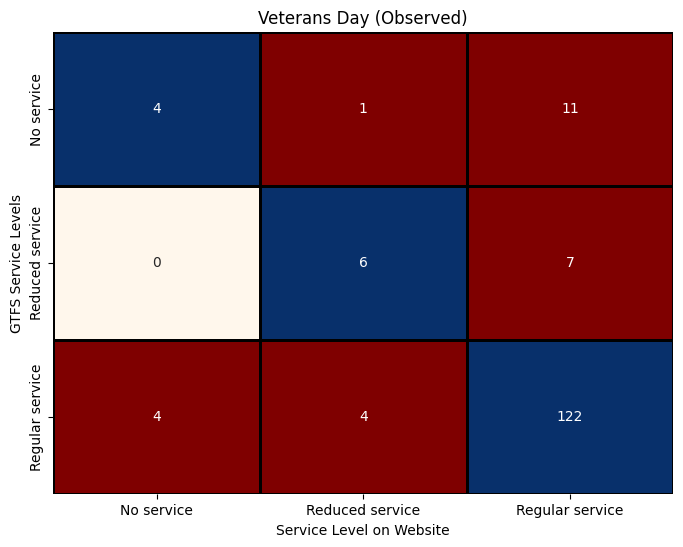

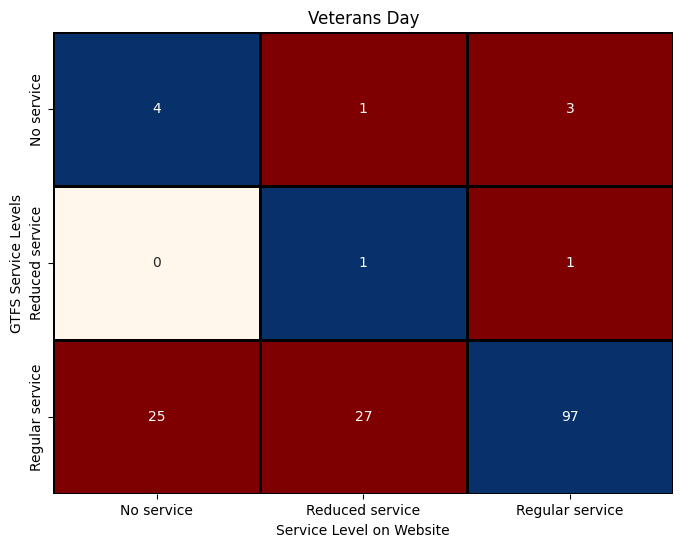

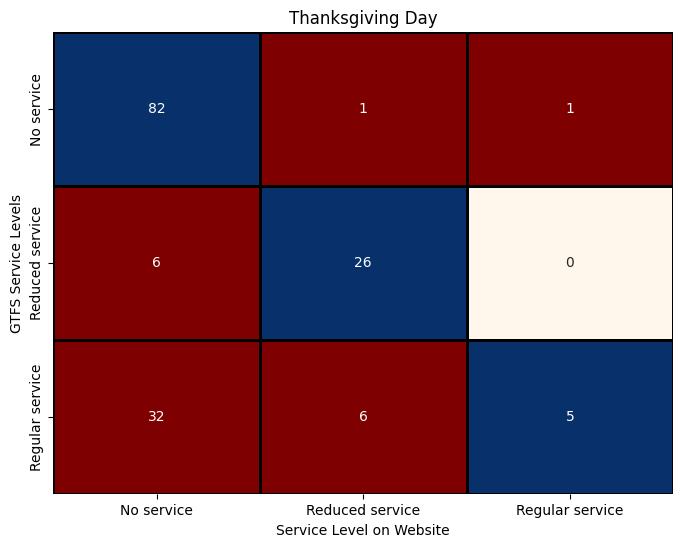

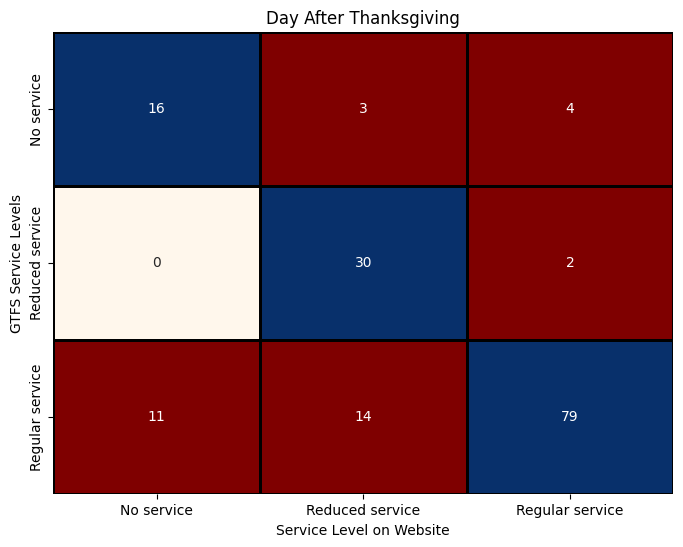

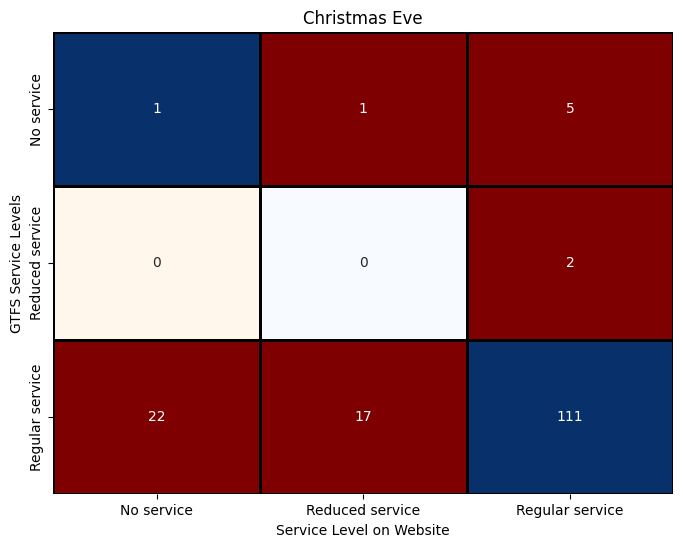

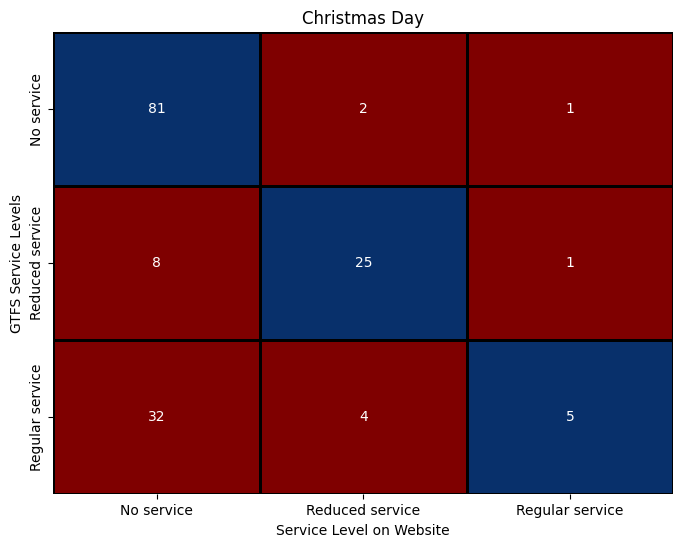

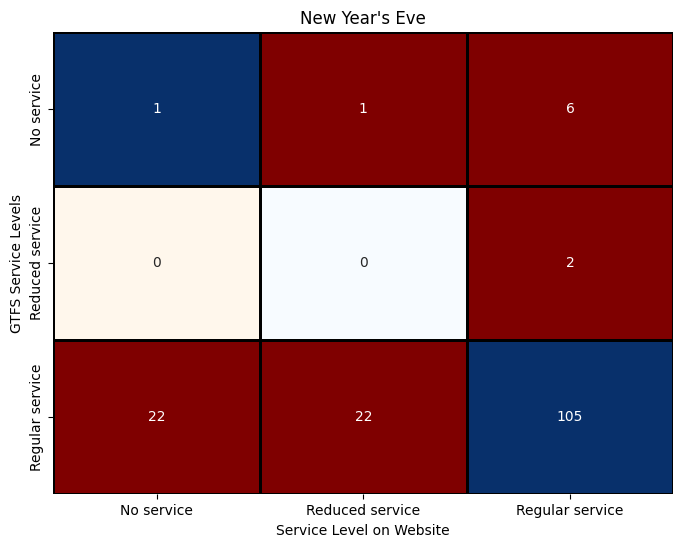

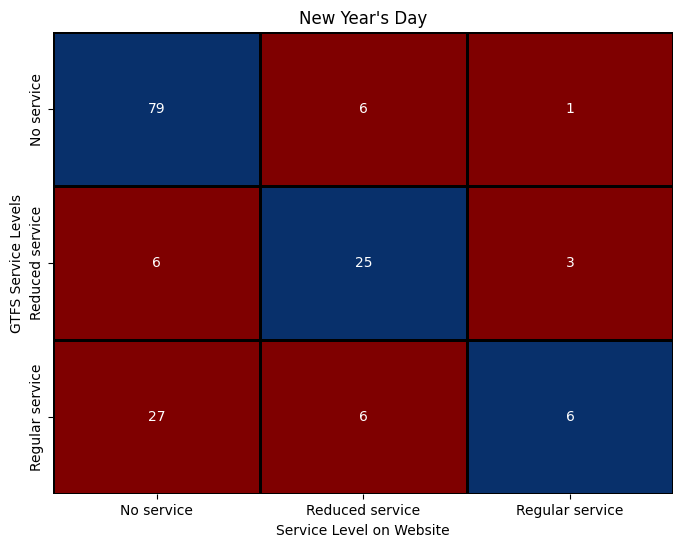

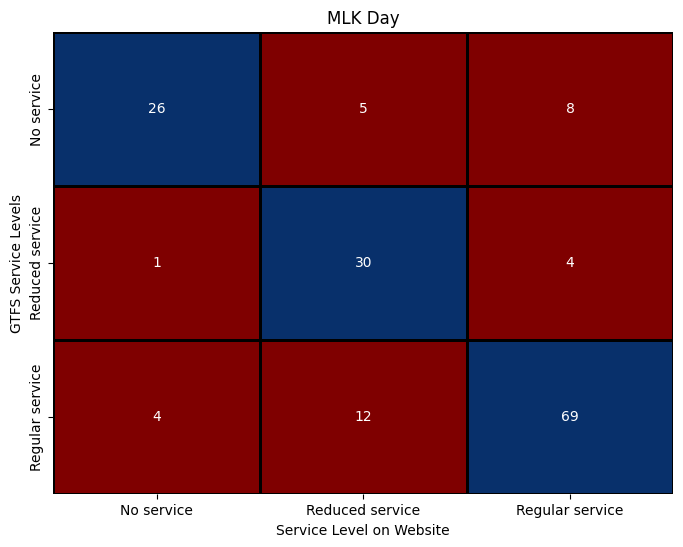

In [36]:
for day in holidays_plus_ref:
    if day['name'] not in ('Reference Weekday', 'Reference Saturday', 'Reference Sunday'):
        plot_confusion_matrices(y_true=day['name'],y_pred=day['website_name'], title=day['name'])

In [37]:
t = []
names = []
for day in holidays_plus_ref:
    if day['name'] not in ('Reference Weekday', 'Reference Saturday', 'Reference Sunday'):
        # plot_confusion_matrices(y_true=day['name'],y_pred=day['website_name'], title=day['name'])
        y_true = day['name']
        y_pred = day['website_name']
        desired_order = ['No service', 'Reduced service', 'Regular service']
        cm = confusion_matrix(y_true=df[y_true], y_pred=df[y_pred], labels=desired_order)
        t += [cm.flatten()]
        names.append(day['name'])
j = np.concatenate((t),axis=0).reshape(9,9)

In [38]:
plot_df = pd.DataFrame(j, index=names, columns = 
["GTFS No service, No service on Website",
 "GTFS No service, Reduced service on Website",
 "GTFS No service, Regular service on Website",
 "GTFS Reduced service, No service on Website",
 "GTFS Reduced service, Reduced service on Website",
 "GTFS Reduced service, Regular service on Website",
 "GTFS Regular service, No service on Website",
 "GTFS Regular service, Reduced service on Website",
 "GTFS Regular service, Regular service on Website"]
                      )
plot_df

,"GTFS No service, No service on Website","GTFS No service, Reduced service on Website","GTFS No service, Regular service on Website","GTFS Reduced service, No service on Website","GTFS Reduced service, Reduced service on Website","GTFS Reduced service, Regular service on Website","GTFS Regular service, No service on Website","GTFS Regular service, Reduced service on Website","GTFS Regular service, Regular service on Website"
Veterans Day (Observed),4,1,11,0,6,7,4,4,122
Veterans Day,4,1,3,0,1,1,25,27,97
Thanksgiving Day,82,1,1,6,26,0,32,6,5
Day After Thanksgiving,16,3,4,0,30,2,11,14,79
Christmas Eve,1,1,5,0,0,2,22,17,111
Christmas Day,81,2,1,8,25,1,32,4,5
New Year's Eve,1,1,6,0,0,2,22,22,105
New Year's Day,79,6,1,6,25,3,27,6,6
MLK Day,26,5,8,1,30,4,4,12,69


In [39]:
plot_df['GTFS matches Website'] = (plot_df['GTFS No service, No service on Website'] 
                                   +plot_df['GTFS Reduced service, Reduced service on Website']
                                   +plot_df['GTFS Regular service, Regular service on Website'])

In [40]:
plot_df['GTFS greater than Website'] = (plot_df['GTFS Reduced service, No service on Website'] 
                                   +plot_df['GTFS Regular service, No service on Website']
                                   +plot_df['GTFS Regular service, Reduced service on Website'])

In [41]:
plot_df['GTFS less than Website'] = (plot_df['GTFS No service, Reduced service on Website'] 
                                   +plot_df['GTFS No service, Regular service on Website']
                                   +plot_df['GTFS Reduced service, Regular service on Website'])

In [42]:
plot_df[['GTFS matches Website', 'GTFS greater than Website', 'GTFS less than Website']].sum(axis=1)

Veterans Day (Observed)    159
Veterans Day               159
Thanksgiving Day           159
Day After Thanksgiving     159
Christmas Eve              159
Christmas Day              159
New Year's Eve             159
New Year's Day             159
MLK Day                    159
dtype: int64

In [43]:
percentages_df = plot_df[['GTFS matches Website', 'GTFS greater than Website', 'GTFS less than Website']].div(
    plot_df[['GTFS matches Website', 'GTFS greater than Website', 'GTFS less than Website']].sum(axis=1),axis=0).round(2)*100
percentages_df

,GTFS matches Website,GTFS greater than Website,GTFS less than Website
Veterans Day (Observed),83.0,5.0,12.0
Veterans Day,64.0,33.0,3.0
Thanksgiving Day,71.0,28.0,1.0
Day After Thanksgiving,79.0,16.0,6.0
Christmas Eve,70.0,25.0,5.0
Christmas Day,70.0,28.0,3.0
New Year's Eve,67.0,28.0,6.0
New Year's Day,69.0,25.0,6.0
MLK Day,79.0,11.0,11.0


Text(0.5, 1.0, 'Comparison of GTFS / Holiday Service Levels by Holiday')

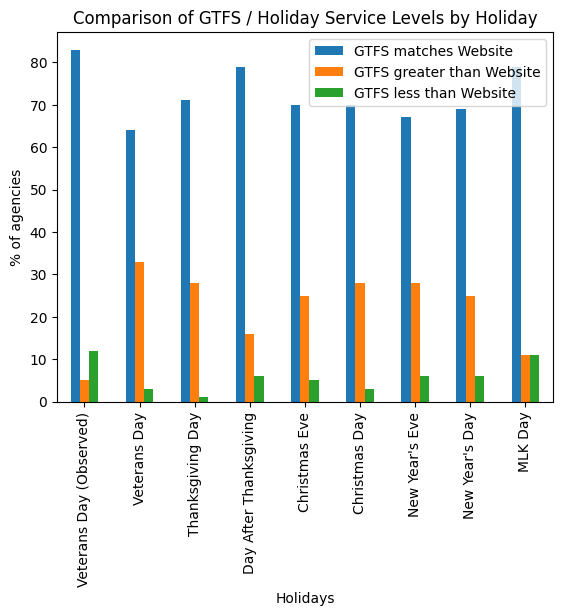

In [44]:
percentages_df.plot.bar()
plt.xlabel('Holidays')
plt.ylabel('% of agencies')
plt.title('Comparison of GTFS / Holiday Service Levels by Holiday')